In [155]:
import boto3
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Noise, Instruction
from braket.devices import LocalSimulator
from braket.jobs.hybrid_job import hybrid_job
from braket.jobs.metrics import log_metric

import string
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

This is the noise free, ideal BV5 circuit:

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │
      ┌───┐ ┌───┐       ┌───┐                   ┌───┐ 
q0 : ─┤ I ├─┤ H ├───●───┤ H ├───────────────────┤ M ├─
      └───┘ └───┘   │   └───┘                   └───┘ 
      ┌───┐ ┌───┐   │         ┌───┐             ┌───┐ 
q1 : ─┤ I ├─┤ H ├───┼─────●───┤ H ├─────────────┤ M ├─
      └───┘ └───┘   │     │   └───┘             └───┘ 
      ┌───┐ ┌───┐   │     │         ┌───┐       ┌───┐ 
q2 : ─┤ I ├─┤ H ├───┼─────┼─────●───┤ H ├───────┤ M ├─
      └───┘ └───┘   │     │     │   └───┘       └───┘ 
      ┌───┐ ┌───┐   │     │     │         ┌───┐ ┌───┐ 
q3 : ─┤ I ├─┤ H ├───┼─────┼─────┼─────●───┤ H ├─┤ M ├─
      └───┘ └───┘   │     │     │     │   └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q4 : ─┤ X ├─┤ H ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ H ├─┤ M ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │

Default Simulator: 
Counter({'11111': 10000})
Correct Counts: 10

Text(0.5, 1.0, 'Ideal BV5 Simulation')

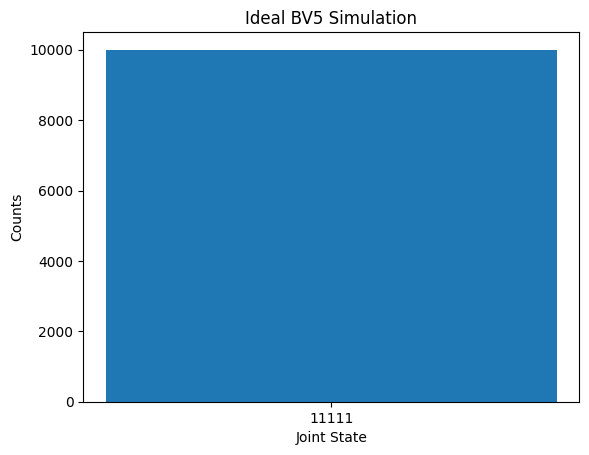

In [251]:
BV5 = Circuit()
BV5.i(0).i(1).i(2).i(3).x(4)
BV5.h(0).h(1).h(2).h(3).h(4)
BV5.cnot(0,4)
BV5.cnot(1,4)
BV5.cnot(2,4)
BV5.cnot(3,4)
BV5.h(0).h(1).h(2).h(3).h(4)
BV5.measure(0).measure(1).measure(2).measure(3).measure(4)

print(BV5)

local_device = LocalSimulator()
task = local_device.run(BV5, shots=10000)
BV5_counts = task.result().measurement_counts
print("\nDefault Simulator: ")
print(BV5_counts)
print("Correct Counts:", BV5_counts['11111'])
plt.bar(BV5_counts.keys(), BV5_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Ideal BV5 Simulation')

This is the noise free, ideal Adder circuit. Assume that A = 1, B = 1, Cin = 1, so Sum = 1 and Cout = 1:

T  : │  0  │  1  │  2  │     3     │  4  │  5  │  6  │
      ┌───┐                                           
q0 : ─┤ X ├───●─────────────────●─────●───────────────
      └───┘   │                 │     │               
      ┌───┐   │                 │     │               
q1 : ─┤ X ├───┼─────●───────────●─────┼─────●─────────
      └───┘   │     │           │     │     │         
      ┌───┐   │     │           │     │     │         
q2 : ─┤ X ├───┼─────┼─────●─────┼─────●─────●─────────
      └───┘   │     │     │     │     │     │         
            ┌─┴─┐ ┌─┴─┐ ┌─┴─┐   │     │     │   ┌───┐ 
q3 : ───────┤ X ├─┤ X ├─┤ X ├───┼─────┼─────┼───┤ M ├─
            └───┘ └───┘ └───┘   │     │     │   └───┘ 
                              ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌───┐ 
q4 : ─────────────────────────┤ X ├─┤ X ├─┤ X ├─┤ M ├─
                              └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │     3     │  4  │  5  │  6  │

Default Simulator: 
Counter({'11': 10000})
Correct Counts: 10000

Text(0.5, 1.0, 'Ideal Adder Simulation')

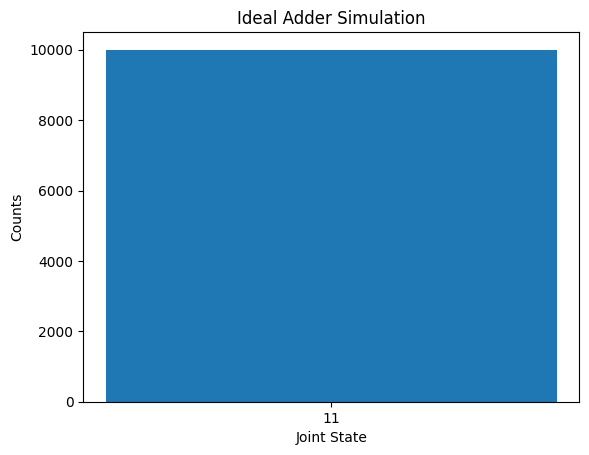

In [252]:
## Adder design from: https://quantumcomputinguk.org/tutorials/performing-addition-on-ibms-quantum-computers

Adder = Circuit()
Adder.x(0).x(1).x(2)
Adder.cnot(0,3)
Adder.cnot(1,3)
Adder.cnot(2,3)
Adder.ccnot(0,1,4)
Adder.ccnot(0,2,4)
Adder.ccnot(1,2,4)
Adder.measure(3).measure(4)

print(Adder)

local_device = LocalSimulator()
task = local_device.run(Adder, shots=10000)
Adder_counts = task.result().measurement_counts
print("\nDefault Simulator: ")
print(Adder_counts)
print("Correct Counts:", Adder_counts['11'])
plt.bar(Adder_counts.keys(), Adder_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Ideal Adder Simulation')

Let's add noise to the circuits for our simulation. We need to manually add noise that is representative of noise that the circuit can expect during execution. 

For Idling noise, the error will vary based on technology used and coherence times of qubits, so we must make a fair assumption. 

Gate noise based on IonQ Hardware, last updated June 3 2024: https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:us-east-1::device/qpu/ionq/Harmony. 

Measurement noise based on CaQR paper: https://doi.org/10.1145/3582016.3582030. Importantly, qubit 4 has a much higher readout error than the rest of the qubits.

Note: Assumes that CCNOT has same error rate as CNOT, which is not true but main idea stays the same (single qubit gates have much less error, while multi-qubit gates have much higher error).

In [253]:
idle_noise = Noise.Depolarizing(probability=0.02)

single_qubit_gate_noise = Noise.Depolarizing(probability=0.0035)
CNOT_qubit_gate_noise = Noise.Depolarizing(probability=0.0302)
CCNOT_qubit_gate_noise = Noise.Depolarizing(probability=0.0302)

qubit0_measurement_noise = Noise.Depolarizing(probability=0.018)
qubit1_measurement_noise = Noise.Depolarizing(probability=0.016)
qubit2_measurement_noise = Noise.Depolarizing(probability=0.0096)
qubit3_measurement_noise = Noise.Depolarizing(probability=0.025)
qubit4_measurement_noise = Noise.Depolarizing(probability=0.13)

First, idle noise will be added to large gaps between operations in both circuits. I will assume that at every stage there is no operation being performed on a qubit, there is a probability of idle error (represented with Identity gate followed by depolarization error). Next, every original gate will also have some probability of error. Finally, each qubit has its own measurement error.

T  : │          0           │          1           │                 2                 │                 3                 │                 4                 │         5          │                   6                   │  7  │
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐       ┌────────────┐                ┌───┐ ┌────────────┐                ┌───┐ ┌────────────┐                ┌───┐ ┌────────────┐ ┌───┐ ┌──────────────┐ ┌─────────────┐  ┌───┐ 
q0 : ─┤ I ├──┤ DEPO(0.02) ├──┤ H ├─┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├────────────────┤ I ├─┤ DEPO(0.02) ├────────────────┤ I ├─┤ DEPO(0.02) ├────────────────┤ I ├─┤ DEPO(0.02) ├─┤ H ├─┤ DEPO(0.0035) ├─┤ DEPO(0.018) ├──┤ M ├─
      └───┘  └────────────┘  └───┘ └──────────────┘   │   └────────────┘                └───┘ └────────────┘                └───┘ └────────────┘                └───┘ └────────────┘ └───┘ └──────────────┘ └─────────────┘  └───┘ 
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐   │       ┌───┐      ┌────────────┐ 

Text(0.5, 1.0, 'Noisy BV5 Simulation')

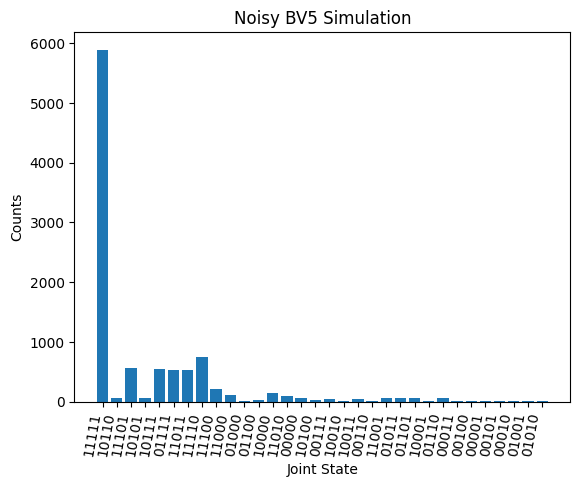

In [256]:
Noisy_BV5 = Circuit()
Noisy_BV5.i(0).i(1).i(2).i(3).x(4)
Noisy_BV5.h(0).h(1).h(2).h(3).h(4)
Noisy_BV5.cnot(0,4).i(1).i(2).i(3)
Noisy_BV5.cnot(1,4).i(0).i(2).i(3)
Noisy_BV5.cnot(2,4).i(0).i(1).i(3)
Noisy_BV5.cnot(3,4).i(0).i(1).i(2)
Noisy_BV5.h(0).h(1).h(2).h(3).h(4)

Noisy_BV5.apply_gate_noise(idle_noise, Gate.I)

Noisy_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H])
Noisy_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot)
Noisy_BV5.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot)

Noisy_BV5.apply_readout_noise(qubit0_measurement_noise, 0)
Noisy_BV5.apply_readout_noise(qubit1_measurement_noise, 1)
Noisy_BV5.apply_readout_noise(qubit2_measurement_noise, 2)
Noisy_BV5.apply_readout_noise(qubit3_measurement_noise, 3)
Noisy_BV5.apply_readout_noise(qubit4_measurement_noise, 4)

Noisy_BV5.measure(0).measure(1).measure(2).measure(3).measure(4)

print(Noisy_BV5)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_BV5, shots=10000)
Noisy_BV5_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_BV5_counts)
print("Correct Counts:", Noisy_BV5_counts['11111'])
plt.bar(Noisy_BV5_counts.keys(), Noisy_BV5_counts.values())
plt.xlabel('Joint State')
plt.xticks(rotation=80, ha="right")
plt.ylabel('Counts')
plt.title('Noisy BV5 Simulation')

Same for adder:

T  : │          0           │                 1                 │                 2                 │         3          │                 4                 │                 5                 │                          6                          │  7  │
      ┌───┐ ┌──────────────┐       ┌────────────┐                ┌───┐ ┌────────────┐                ┌───┐ ┌────────────┐       ┌────────────┐                      ┌────────────┐                ┌───┐ ┌────────────┐ ┌─────────────┐                        
q0 : ─┤ X ├─┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├────────────────┤ I ├─┤ DEPO(0.02) ├────────────────┤ I ├─┤ DEPO(0.02) ├───●───┤ DEPO(0.03) ├──────────────────●───┤ DEPO(0.03) ├────────────────┤ I ├─┤ DEPO(0.02) ├─┤ DEPO(0.018) ├────────────────────────
      └───┘ └──────────────┘   │   └────────────┘                └───┘ └────────────┘                └───┘ └────────────┘   │   └────────────┘                  │   └────────────┘                └───┘ └────────────┘ └─────────────┘     

Text(0.5, 1.0, 'Noisy Adder Simulation')

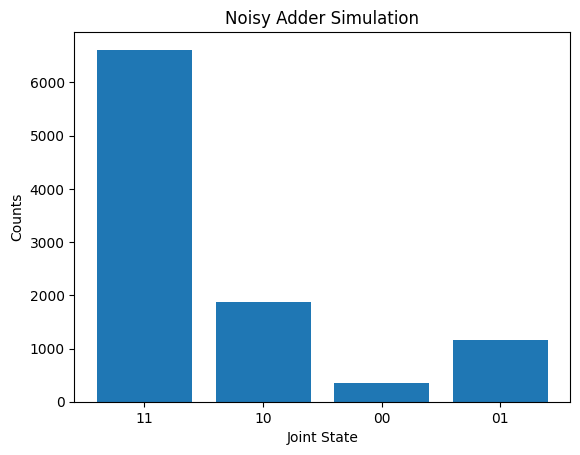

In [258]:
Noisy_Adder = Circuit()
Noisy_Adder.x(0).x(1).x(2).i(3).i(4)
Noisy_Adder.cnot(0,3).i(1).i(2).i(4)
Noisy_Adder.cnot(1,3).i(0).i(2).i(4)
Noisy_Adder.cnot(2,3).i(0).i(1).i(4)
Noisy_Adder.ccnot(0,1,4).i(2).i(3)
Noisy_Adder.ccnot(0,2,4).i(1).i(3)
Noisy_Adder.ccnot(1,2,4).i(0).i(3)

Noisy_Adder.apply_gate_noise(idle_noise, Gate.I)

Noisy_Adder.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H, Gate.Y])
Noisy_Adder.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot)
Noisy_Adder.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot)

Noisy_Adder.apply_readout_noise(qubit0_measurement_noise, 0)
Noisy_Adder.apply_readout_noise(qubit1_measurement_noise, 1)
Noisy_Adder.apply_readout_noise(qubit2_measurement_noise, 2)
Noisy_Adder.apply_readout_noise(qubit3_measurement_noise, 3)
Noisy_Adder.apply_readout_noise(qubit4_measurement_noise, 4)

Noisy_Adder.measure(3).measure(4)

print(Noisy_Adder)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_Adder, shots=10000)
Noisy_Adder_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_Adder_counts)
print("Correct Counts:", Noisy_Adder_counts['11'])
plt.bar(Noisy_Adder_counts.keys(), Noisy_Adder_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Noisy Adder Simulation')

Now that we have our idling, gate, and readout errors set, we need to consider where to add our XY-4 DD protocol. Normally, this would be done through the ADAPT compilation process, but there is a lack of open-access to their code, so we must replicate this process manually. This replication assumes that if DD is applied to a qubit, the idle window between its last and next operations will not have any idle error.

Because our test circuits are small enough, we are able to consider where to add DD analytically. This can be done by comparing the probabilities of a correct outcome after noise is applied:

* Idle Noise Applied Once: 0.98

* Idle Noise Applied Twice: (0.98)^2 = 0.9604

* Idle Noise Applied Three Times: (0.98)^3 = 0.9412

* DD-Protocol = X-Y-X-Y-X-Y-X-Y = 8 single qubit gates = (0.9965)^8 = 0.9723

We can see from the analysis above that applying DD will not be worth it if idle noise is only applied once between operations, but DD will be worth it if idle noise is applied more than once between operations. DD does not take multiple-qubit gates into consideration. Therefore, we can recreate our circuits with DD applied in windows that would be beneficial, similar to the idea of ADAPT. First, we can simplify the DD process and create an equivalent gate so it is mathematically equivalent but visually easier:

In [259]:
XY_4_Unitary = numpy.array([[1,0],
                            [0,1]])

XY_4_gate = Gate.Unitary(matrix=XY_4_Unitary, display_name="XY-4")

XY4_gate_noise = Noise.Depolarizing(probability=0.02766)

print("XY-4 Unitary:")
print(XY_4_Unitary)


XY-4 Unitary:
[[1 0]
 [0 1]]


Now we recreate our circuits with the XY-4 DD protocol in place of two (or more) idle times, starting with BV5:

T  : │          0           │          1           │                 2                  │           3            │            4            │          5           │                        6                        │  7  │
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐       ┌────────────┐                 ┌──────┐ ┌─────────────┐  ┌───┐   ┌──────────────┐                        ┌─────────────┐                                   ┌───┐ 
q0 : ─┤ I ├──┤ DEPO(0.02) ├──┤ H ├─┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├─────────────────┤ XY-4 ├─┤ DEPO(0.028) ├──┤ H ├───┤ DEPO(0.0035) ├────────────────────────┤ DEPO(0.018) ├───────────────────────────────────┤ M ├─
      └───┘  └────────────┘  └───┘ └──────────────┘   │   └────────────┘                 └──────┘ └─────────────┘  └───┘   └──────────────┘                        └─────────────┘                                   └───┘ 
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐   │       ┌───┐      ┌────────────┐           ┌────────────┐  ┌─────

Text(0.5, 1.0, 'Noisy DD BV5 Simulation')

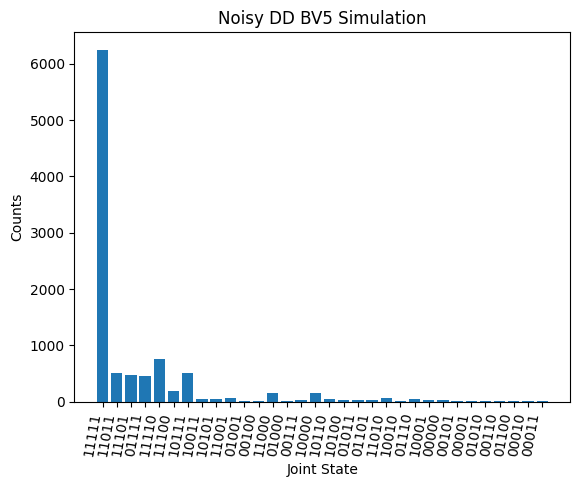

In [261]:
Noisy_DD_BV5 = Circuit()
Noisy_DD_BV5.i(0).i(1).i(2).i(3).x(4)
Noisy_DD_BV5.h(0).h(1).h(2).h(3).h(4)
Noisy_DD_BV5.cnot(0,4).i(1).unitary(matrix=XY_4_Unitary, targets=[2], display_name="XY-4").unitary(matrix=XY_4_Unitary, targets=[3], display_name="XY-4")
Noisy_DD_BV5.cnot(1,4).unitary(matrix=XY_4_Unitary, targets=[0], display_name="XY-4")
Noisy_DD_BV5.cnot(2,4).unitary(matrix=XY_4_Unitary, targets=[1], display_name="XY-4")
Noisy_DD_BV5.cnot(3,4).i(2)
Noisy_DD_BV5.h(0).h(1).h(2).h(3).h(4)

Noisy_DD_BV5.apply_gate_noise(idle_noise, Gate.I)

Noisy_DD_BV5.apply_gate_noise(XY4_gate_noise, target_unitary=XY_4_Unitary)

Noisy_DD_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H])
Noisy_DD_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot)
Noisy_DD_BV5.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot)

Noisy_DD_BV5.apply_readout_noise(qubit0_measurement_noise, 0)
Noisy_DD_BV5.apply_readout_noise(qubit1_measurement_noise, 1)
Noisy_DD_BV5.apply_readout_noise(qubit2_measurement_noise, 2)
Noisy_DD_BV5.apply_readout_noise(qubit3_measurement_noise, 3)
Noisy_DD_BV5.apply_readout_noise(qubit4_measurement_noise, 4)

Noisy_DD_BV5.measure(0).measure(1).measure(2).measure(3).measure(4)

print(Noisy_DD_BV5)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_DD_BV5, shots=10000)
Noisy_DD_BV5_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_DD_BV5_counts)
print("Correct Counts:", Noisy_DD_BV5_counts['11111'])
plt.bar(Noisy_DD_BV5_counts.keys(), Noisy_DD_BV5_counts.values())
plt.xlabel('Joint State')
plt.xticks(rotation=80, ha="right")
plt.ylabel('Counts')
plt.title('Noisy DD BV5 Simulation')

Repeat DD substitution for Adder circuit:

T  : │            0            │                 1                  │           2            │         3          │                 4                  │                 5                 │                  6                   │  7  │
       ┌───┐   ┌──────────────┐       ┌────────────┐                 ┌──────┐ ┌─────────────┐                            ┌────────────┐                       ┌────────────┐                ┌───┐ ┌────────────┐  ┌─────────────┐        
q0 : ──┤ X ├───┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├─────────────────┤ XY-4 ├─┤ DEPO(0.028) ├────────────────────────●───┤ DEPO(0.03) ├───────────────────●───┤ DEPO(0.03) ├────────────────┤ I ├─┤ DEPO(0.02) ├──┤ DEPO(0.018) ├────────
       └───┘   └──────────────┘   │   └────────────┘                 └──────┘ └─────────────┘                        │   └────────────┘                   │   └────────────┘                └───┘ └────────────┘  └─────────────┘        
       ┌───┐   ┌──────────────┐   │       ┌───┐      ┌──────────

Text(0.5, 1.0, 'Noisy DD Adder Simulation')

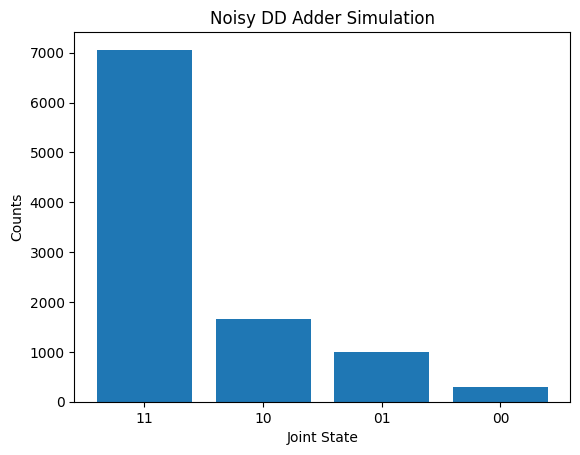

In [276]:
Noisy_DD_Adder = Circuit()
Noisy_DD_Adder.x(0).x(1).x(2).i(3).unitary(matrix=XY_4_Unitary, targets=[4], display_name="XY-4")
Noisy_DD_Adder.cnot(0,3).i(1).unitary(matrix=XY_4_Unitary, targets=[2], display_name="XY-4")
Noisy_DD_Adder.cnot(1,3).unitary(matrix=XY_4_Unitary, targets=[0], display_name="XY-4")
Noisy_DD_Adder.cnot(2,3).i(1)
Noisy_DD_Adder.ccnot(0,1,4).i(2).unitary(matrix=XY_4_Unitary, targets=[3], display_name="XY-4")
Noisy_DD_Adder.ccnot(0,2,4).i(1)
Noisy_DD_Adder.ccnot(1,2,4).i(0)

Noisy_DD_Adder.apply_gate_noise(idle_noise, Gate.I)

Noisy_DD_Adder.apply_gate_noise(XY4_gate_noise, target_unitary=XY_4_Unitary)

Noisy_DD_Adder.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H, Gate.Y])
Noisy_DD_Adder.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot)
Noisy_DD_Adder.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot)

Noisy_DD_Adder.apply_readout_noise(qubit0_measurement_noise, 0)
Noisy_DD_Adder.apply_readout_noise(qubit1_measurement_noise, 1)
Noisy_DD_Adder.apply_readout_noise(qubit2_measurement_noise, 2)
Noisy_DD_Adder.apply_readout_noise(qubit3_measurement_noise, 3)
Noisy_DD_Adder.apply_readout_noise(qubit4_measurement_noise, 4)

Noisy_DD_Adder.measure(3).measure(4)

print(Noisy_DD_Adder)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_DD_Adder, shots=10000)
Noisy_DD_Adder_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_DD_Adder_counts)
print("Correct Counts:", Noisy_DD_Adder_counts['11'])
plt.bar(Noisy_DD_Adder_counts.keys(), Noisy_DD_Adder_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Noisy DD Adder Simulation')

At this point, we have simulated the ADAPT procedure and added DD to locations that would improve fidelity. Now it is time to consider the possibility of mid-circuit measurement.

In future works, the compiler would have to look at the decoy circuit provided by the ADAPT compilation process and determine when a measurement can be made early. As we do not have access to these decoy circuits, we can manually observe when measurement can be made early. If the qubit does not have any future operations or act as a control for any future operations, the measurement can be made early. This will be done below, starting with BV5:

T  : │          0           │          1           │                 2                  │          3           │          4           │          5           │                        6                        │  7  │
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐       ┌────────────┐                 ┌───┐ ┌──────────────┐                                               ┌─────────────┐                                   ┌───┐ 
q0 : ─┤ I ├──┤ DEPO(0.02) ├──┤ H ├─┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├─────────────────┤ H ├─┤ DEPO(0.0035) ├───────────────────────────────────────────────┤ DEPO(0.018) ├───────────────────────────────────┤ M ├─
      └───┘  └────────────┘  └───┘ └──────────────┘   │   └────────────┘                 └───┘ └──────────────┘                                               └─────────────┘                                   └───┘ 
      ┌───┐  ┌────────────┐  ┌───┐ ┌──────────────┐   │       ┌───┐      ┌────────────┐         ┌────────────┐  ┌───┐ ┌──────────────┐      

Text(0.5, 1.0, 'Noisy DD Mid-Measurement BV5 Simulation')

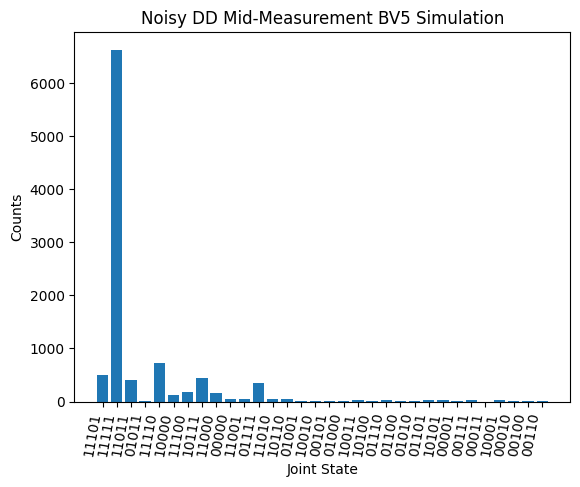

In [264]:
#Start circuit
Noisy_DD_MidMeasure_BV5 = Circuit()
Noisy_DD_MidMeasure_BV5.i(0).i(1).i(2).i(3).x(4)
Noisy_DD_MidMeasure_BV5.h(0).h(1).h(2).h(3).h(4)
Noisy_DD_MidMeasure_BV5.cnot(0,4).i(1).unitary(matrix=XY_4_Unitary, targets=[2], display_name="XY-4").unitary(matrix=XY_4_Unitary, targets=[3], display_name="XY-4")
Noisy_DD_MidMeasure_BV5.cnot(1,4).h(0)

#Qubit 0 finished all gates, need to add noise before measurement
Noisy_DD_MidMeasure_BV5.apply_gate_noise(idle_noise, Gate.I, target_qubits=0)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H], target_qubits=0)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot, target_qubits=0)
Noisy_DD_MidMeasure_BV5.apply_readout_noise(qubit0_measurement_noise, target_qubits=0)

#Continue
Noisy_DD_MidMeasure_BV5.h(1)

#Qubit 1 finished all gates, need to add noise before measurement
Noisy_DD_MidMeasure_BV5.apply_gate_noise(idle_noise, Gate.I, target_qubits=1)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H], target_qubits=1)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot, target_qubits=1)
Noisy_DD_MidMeasure_BV5.apply_readout_noise(qubit1_measurement_noise, 1)

#Continue
Noisy_DD_MidMeasure_BV5.cnot(2,4).h(2)

#Qubit 2 finished all gates, need to add noise before measurement
Noisy_DD_MidMeasure_BV5.apply_gate_noise(idle_noise, Gate.I, target_qubits=2)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(XY4_gate_noise, target_unitary=XY_4_Unitary,target_qubits=[2])
Noisy_DD_MidMeasure_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H], target_qubits=2)
Noisy_DD_MidMeasure_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot, target_qubits=2)
Noisy_DD_MidMeasure_BV5.apply_readout_noise(qubit2_measurement_noise, 2)

#Continue
Noisy_DD_MidMeasure_BV5.cnot(3,4)
Noisy_DD_MidMeasure_BV5.h(3).h(4)

#Qubits 3 and 4 finished all gates, need to add noise before measurement
Noisy_DD_MidMeasure_BV5.apply_gate_noise(idle_noise, Gate.I, target_qubits=[3,4])
Noisy_DD_MidMeasure_BV5.apply_gate_noise(XY4_gate_noise, target_unitary=XY_4_Unitary,target_qubits=[3,4])
Noisy_DD_MidMeasure_BV5.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H],target_qubits=[3,4])
Noisy_DD_MidMeasure_BV5.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot,target_qubits=[3,4])
Noisy_DD_MidMeasure_BV5.apply_readout_noise(qubit3_measurement_noise, 3)
Noisy_DD_MidMeasure_BV5.apply_readout_noise(qubit4_measurement_noise, 4)

# The measurements visually look like they are measured at the end, but there is no idle noise being added.
# Had to do this until Amazon fixes their measure method, since measuring individually and adding qubit-specific
# noise does not work if later noise is added to the other qubits (weird bug... but this is mathematically 
# the same, just looks like measurements are at the end).
Noisy_DD_MidMeasure_BV5.measure(0).measure(1).measure(2).measure(3).measure(4)

print(Noisy_DD_MidMeasure_BV5)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_DD_MidMeasure_BV5, shots=10000)
Noisy_DD_MidMeasure_BV5_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_DD_MidMeasure_BV5_counts)
print("Correct Counts:", Noisy_DD_MidMeasure_BV5_counts['11111'])
plt.bar(Noisy_DD_MidMeasure_BV5_counts.keys(), Noisy_DD_MidMeasure_BV5_counts.values())
plt.xlabel('Joint State')
plt.xticks(rotation=80, ha="right")
plt.ylabel('Counts')
plt.title('Noisy DD Mid-Measurement BV5 Simulation')

Now apply mid-circuit measurement to the Adder:

T  : │            0            │                 1                  │           2            │         3          │                 4                 │                 5                 │                  6                   │  7  │
       ┌───┐   ┌──────────────┐       ┌────────────┐                 ┌──────┐ ┌─────────────┐                            ┌────────────┐                      ┌────────────┐                ┌───┐ ┌────────────┐  ┌─────────────┐        
q0 : ──┤ X ├───┤ DEPO(0.0035) ├───●───┤ DEPO(0.03) ├─────────────────┤ XY-4 ├─┤ DEPO(0.028) ├────────────────────────●───┤ DEPO(0.03) ├──────────────────●───┤ DEPO(0.03) ├────────────────┤ I ├─┤ DEPO(0.02) ├──┤ DEPO(0.018) ├────────
       └───┘   └──────────────┘   │   └────────────┘                 └──────┘ └─────────────┘                        │   └────────────┘                  │   └────────────┘                └───┘ └────────────┘  └─────────────┘        
       ┌───┐   ┌──────────────┐   │       ┌───┐      ┌────────────┐ 

Text(0.5, 1.0, 'Noisy DD Adder Simulation')

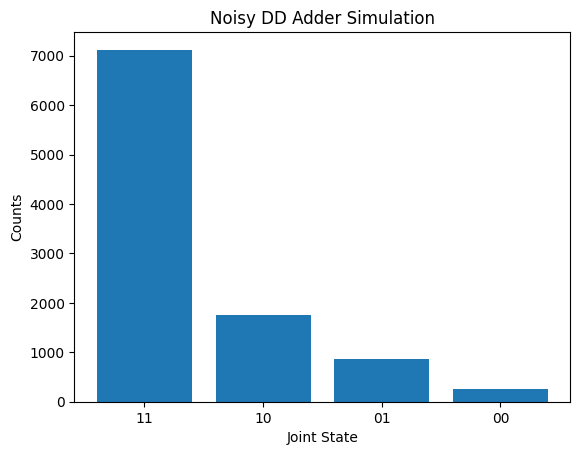

In [279]:
#Start Circuit
Noisy_DD_MidMeasure_Adder = Circuit()
Noisy_DD_MidMeasure_Adder.x(0).x(1).x(2).i(3).unitary(matrix=XY_4_Unitary, targets=[4], display_name="XY-4")
Noisy_DD_MidMeasure_Adder.cnot(0,3).i(1).unitary(matrix=XY_4_Unitary, targets=[2], display_name="XY-4")
Noisy_DD_MidMeasure_Adder.cnot(1,3).unitary(matrix=XY_4_Unitary, targets=[0], display_name="XY-4")
Noisy_DD_MidMeasure_Adder.cnot(2,3).i(1)

#Qubit 3 finished all gates, need to add noise before measurement
Noisy_DD_MidMeasure_Adder.apply_gate_noise(idle_noise, Gate.I, target_qubits=3)
Noisy_DD_MidMeasure_Adder.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H], target_qubits=3)
Noisy_DD_MidMeasure_Adder.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot, target_qubits=3)
Noisy_DD_MidMeasure_Adder.apply_readout_noise(qubit3_measurement_noise, target_qubits=3)
Noisy_DD_MidMeasure_Adder.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot, target_qubits=3)

#Continue
Noisy_DD_MidMeasure_Adder.ccnot(0,1,4).i(2)
Noisy_DD_MidMeasure_Adder.ccnot(0,2,4).i(1)
Noisy_DD_MidMeasure_Adder.ccnot(1,2,4).i(0)

#Rest of the qubits are done, add noise to them
Noisy_DD_MidMeasure_Adder.apply_gate_noise(idle_noise, Gate.I, target_qubits=[0,1,2,4])
Noisy_DD_MidMeasure_Adder.apply_gate_noise(XY4_gate_noise, target_unitary=XY_4_Unitary, target_qubits=[0,1,2,4])
Noisy_DD_MidMeasure_Adder.apply_gate_noise(single_qubit_gate_noise, [Gate.X, Gate.H, Gate.Y], target_qubits=[0,1,2,4])
Noisy_DD_MidMeasure_Adder.apply_gate_noise(CNOT_qubit_gate_noise, Gate.CNot, target_qubits=[0,1,2,4])
Noisy_DD_MidMeasure_Adder.apply_gate_noise(CCNOT_qubit_gate_noise, Gate.CCNot, target_qubits=[0,1,2,4])

Noisy_DD_MidMeasure_Adder.apply_readout_noise(qubit0_measurement_noise, 0)
Noisy_DD_MidMeasure_Adder.apply_readout_noise(qubit1_measurement_noise, 1)
Noisy_DD_MidMeasure_Adder.apply_readout_noise(qubit2_measurement_noise, 2)
Noisy_DD_MidMeasure_Adder.apply_readout_noise(qubit4_measurement_noise, 4)

Noisy_DD_MidMeasure_Adder.measure(3).measure(4)

print(Noisy_DD_MidMeasure_Adder)

noisy_local_device = LocalSimulator("braket_dm")
task = noisy_local_device.run(Noisy_DD_MidMeasure_Adder, shots=10000)
Noisy_DD_MidMeasure_Adder_counts = task.result().measurement_counts
print("\nNoisy Simulator: ")
print(Noisy_DD_MidMeasure_Adder_counts)
print("Correct Counts:", Noisy_DD_MidMeasure_Adder_counts['11'])
plt.bar(Noisy_DD_MidMeasure_Adder_counts.keys(), Noisy_DD_MidMeasure_Adder_counts.values())
plt.xlabel('Joint State')
plt.ylabel('Counts')
plt.title('Noisy DD Adder Simulation')

We have successfully created a circuit that follows the ADAPT idea and includes mid-circuit measurements. Time to compare the results:

In [281]:
print("COMPARING BV5...")
print("Base Case:", Noisy_BV5_counts['11111'])
print("Applied DD:", Noisy_DD_BV5_counts['11111'])
print("Applied DD and Mid-Measurement:", Noisy_DD_MidMeasure_BV5_counts['11111'])

print("\nCOMPARING ADDER...")
print("Base Case:", Noisy_Adder_counts['11'])
print("Applied DD:", Noisy_DD_Adder_counts['11'])
print("Applied DD and Mid-Measurement:", Noisy_DD_MidMeasure_Adder_counts['11'])

COMPARING BV5...
Base Case: 5892
Applied DD: 6249
Applied DD and Mid-Measurement: 6628

COMPARING ADDER...
Base Case: 6614
Applied DD: 7059
Applied DD and Mid-Measurement: 7120
